In [1]:
import numpy as np
from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt
import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

np.random.seed(10)

ModuleNotFoundError: No module named 'tqdm'

In [2]:
def sample_cov(Xens1,Xens2):
    #assume that Xens is a 2d-array
    Xmean1 = np.mean(Xens1,0)
    Xpert1 = Xens1 - np.repeat(Xmean1[np.newaxis],Xens1.shape[0],0)
    Xmean2 = np.mean(Xens2,0)
    Xpert2 = Xens2 - np.repeat(Xmean2[np.newaxis],Xens2.shape[0],0)
    C = Xpert1.T.dot(Xpert2)/(Xens1.shape[0]-1.)
    return C

In [3]:
def L63_step(X,dt): #integrate Lorenz 63 model using 4-th order Runge-Kutta method 
    sigma = 10.;rho = 28.;beta = 8./3.
    
    X1 = np.copy(X)
    k1 = np.zeros(X1.shape)
    k1[:,0] = sigma*(X1[:,1] - X1[:,0])
    k1[:,1] = X1[:,0]*(rho-X1[:,2]) - X1[:,1]
    k1[:,2] = X1[:,0]*X1[:,1] - beta*X1[:,2]
    
    X2 = np.copy(X+k1/2*dt)
    k2 = np.zeros(X.shape)
    k2[:,0] = sigma*(X2[:,1] - X2[:,0])
    k2[:,1] = X2[:,0]*(rho-X2[:,2]) - X2[:,1]
    k2[:,2] = X2[:,0]*X2[:,1] - beta*X2[:,2]    

    X3 = np.copy(X+k2/2*dt)
    k3 = np.zeros(X.shape)
    k3[:,0] = sigma*(X3[:,1] - X3[:,0])
    k3[:,1] = X3[:,0]*(rho-X3[:,2]) - X3[:,1]
    k3[:,2] = X3[:,0]*X3[:,1] - beta*X3[:,2]
    
    X4 = np.copy(X+k3*dt)
    k4 = np.zeros(X.shape)
    k4[:,0] = sigma*(X4[:,1] - X4[:,0])
    k4[:,1] = X4[:,0]*(rho-X4[:,2]) - X4[:,1]
    k4[:,2] = X4[:,0]*X4[:,1] - beta*X4[:,2]
    
    Xnew = X + dt/6.*(k1+2*k2+2*k3+k4)
    return Xnew

In [4]:
def get_obs(Xtrue,H,R,dt,dt_obs):
    #assume H is an 1d array, i.e. observations are scalars.
    #assume R is a scalar
    nt = int(round(dt_obs/dt))
    Yobs_tmp = Xtrue.dot(H) + np.sqrt(R)*np.random.randn(Xtrue.shape[0])
    Yobs = Yobs_tmp*np.nan
    Yobs[0:Yobs_tmp.shape[0]:nt] = Yobs_tmp[0:Yobs_tmp.shape[0]:nt]
    return Yobs

In [5]:
def EnKF_forward(Xfens,yo, H, R):
    #assume Xens is 2d array
    #assume yo and R are scalars
    #assume H is 1d array
    Ne = Xfens.shape[0]
    Pf = sample_cov(Xfens,Xfens)
    K = Pf.dot(H)/(R + H.dot(Pf).dot(H))
    Xaens = Xfens + np.outer(yo - Xfens.dot(H) + np.sqrt(R)*np.random.randn(Ne), K)
    xamean = np.mean(Xaens,0)
    Pa = sample_cov(Xaens,Xaens)
    return xamean,Xaens,Pa   

In [6]:
def EnKS_backward(Xaenst,Xfenst1,Xsenst1):
    Ne = Xaenst.shape[0]
    xameant = np.mean(Xaenst,0)
    Xapertt = Xaenst - np.repeat(xameant[np.newaxis],Ne,axis = 0)    
    xfmeant1 = np.mean(Xfenst1,0)
    Xfpertt1 = Xfenst1 - np.repeat(xfmeant1[np.newaxis],Ne,axis = 0)  
    xsenst1 = np.mean(Xsenst1,0)
    Xspertt1 = Xsenst1 - np.repeat(xsmeant1[np.newaxis],Ne,axis = 0) 
    
    Ct = Xapertt.T.dot(Xfpertt1)/(Ne-1)
    Pft1 = Xfpertt1.T.dot(Xfpertt1)/(Ne-1)
    Jt = Ct.dot(np.linalg.inv(Pft1))
    Xsenst = Xaenst + (Xsenst1 - Xfenst1).dot(Jt.T)
    xsmeant = np.mean(Xsenst,0)
    Xspertt = Xsenst - np.repeat(xsmeant[np.newaxis],Ne,axis = 0)
    Pst = Xspertt.T.dot(Xspertt)/(Ne-1)
    return xsmeant,Xsenst,Pst

In [7]:
dt =  0.01
X_init = np.random.randn(1,3) #generate initial value with random number
for i in range(1000):  #model spin-up
    X_init = L63_step(X_init,dt)

In [8]:
#generate the catalog (3d, 1d, lag) and background truth
L_lag = 7
T_c = 10000
T_t = 1000
H_true = np.array([1.,0.,0.])
catalog3d = np.zeros((T_c,3))
catalog3d[0] = np.copy(X_init)
for i in range(1,T_c):
    catalog3d[i:i+1] = L63_step(catalog3d[i-1:i],dt)
    
catalog1d = np.copy(catalog3d[:,0:1])

catalog_lag = np.zeros((T_c-2*L_lag,3))
catalog_lag[:,0] = np.copy(catalog3d[2*L_lag:].dot(H_true))
catalog_lag[:,1] = np.copy(catalog3d[L_lag:-L_lag].dot(H_true))
catalog_lag[:,2] = np.copy(catalog3d[0:-2*L_lag].dot(H_true))



x_tmp = np.copy(catalog3d[-1:])
for i in range(10000):
    x_tmp = L63_step(x_tmp,dt)
    
X3d_true = np.zeros((T_t,3))
X3d_true[0] = np.copy(x_tmp[0])
for i in range(1,T_t):
    X3d_true[i:i+1] = L63_step(X3d_true[i-1:i],dt)
    
x_tmp = np.copy(X3d_true[-1:])
for i in range(1000):
    x_tmp = L63_step(x_tmp,dt)

/home/zhenyicun/.local/lib/python2.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


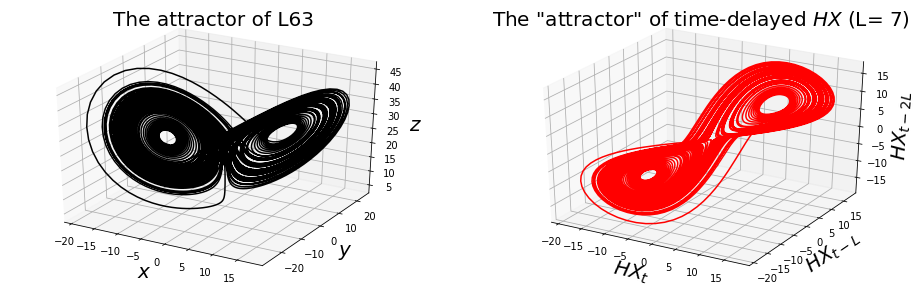

In [9]:
fig1 = plt.figure(figsize=(16,5))
ax1_1 = fig1.add_subplot(121,projection='3d')
ax1_1.plot(catalog3d[:,0],catalog3d[:,1],catalog3d[:,2],'k')
ax1_1.set_title('The attractor of L63',fontsize = 20)
ax1_1.set_xlabel('$x$',fontsize=20);ax1_1.set_ylabel('$y$',fontsize=20);ax1_1.set_zlabel('$z$',fontsize=20)
ax1_2 = fig1.add_subplot(122,projection='3d')
ax1_2.plot(catalog_lag[:,0],catalog_lag[:,1],catalog_lag[:,2],'r')
ax1_2.set_title('The "attractor" of time-delayed $HX$ (L= '+str(L_lag)+')',fontsize = 20)
ax1_2.set_xlabel('$HX_t$',fontsize=20);ax1_2.set_ylabel('$HX_{t-L}$',fontsize=20);ax1_2.set_zlabel('$HX_{t-2L}$',fontsize=20)
fig1.show()

In [10]:
Xtrue = np.copy(X3d_true)
T = Xtrue.shape[0]
Ne = 50
dt_obs = 0.08
R = 2.0
AF_k = 50
n  = 3
if n == 3:
    catalog = np.copy(catalog_lag)
    H_DA = np.array([1.,0.,0.]) #this does not change
elif n == 1:
    catalog = np.copy(catalog1d)
    H_DA = np.array([1.]) # this does not change
    
analogs = np.copy(catalog[0:-1])
successors = np.copy(catalog[1:])

Yobs = get_obs(Xtrue,H_true,R,dt,dt_obs)

Xensseq = Xtrue[0].dot(H_true)*(np.zeros((Ne,2*L_lag+1)) + 1.) + np.random.randn(Ne,2*L_lag+1)
Xens_tmp = np.zeros((Ne,n))
for i in range(n):
    Xens_tmp[:,i] = np.copy(Xensseq[:,i*L_lag])

Xfens = np.zeros((Xtrue.shape[0], Ne, n))
Xpens = np.zeros((Xtrue.shape[0], Ne, n))
Xaens = np.zeros((Xtrue.shape[0], Ne, n))
Xsens = np.zeros((Xtrue.shape[0], Ne, n))
Pf_all = np.zeros((T,n,n))
Pa_all = np.zeros((T,n,n))
Ps_all = np.zeros((T,n,n))

Xfens[0] = np.copy(Xens_tmp)
Xpens[0] = np.copy(Xens_tmp)
Pf_all[0] = sample_cov(Xens_tmp,Xens_tmp)

# Programming Assignment #1

In this assignment, you are supposed to complete the code for analog forecast (locally linear version).

More specifically, you need to completely write the code for weighted linear regression algorithm (<font color='blue'>linear_regresson_weighted</font>) and <font color='blue'>Analog_forecast</font> by yourself. By completing this assignment, you will have your own code of analog forecast. The algorithm of linear regression and analog forecast is the following. 

### Ordinary Least Squares Regression

Given $X\in\mathbb{R}^{N\times n}$ and $Y\in\mathbb{R}^{N\times p}$ (assuming that $N>n+1,p+1$), we want to find $A\in\mathbb{R}^{n\times p}$, so that $\|Y-XA\|^2$ is minimal. Here the matrix norm $\|a\|^2$ refers to the sum of the squares of all the elements of $a$.

We have $\|a\|^2 = Tr(aa^{\top}) = Tr(a^{\top}a)$ for any matrix $a$.
\begin{align*}
(Y-XA)^{\top}(Y-XA) &= A^{\top}X^{\top}XA - A^{\top}X^{\top}Y - Y^{\top}XA + Y^{\top}Y \nonumber \\
&= (\sqrt{X^{\top}X}A)^{\top}(\sqrt{X^{\top}X}A) - A^{\top}X^{\top}Y - Y^{\top}XA + Y^{\top}Y \nonumber \\
& \text{Let $B = \sqrt{X^{\top}X}A$} \nonumber \\
&= B^{\top}B - B^{\top}(\sqrt{X^{\top}X})^{-1}X^{\top}Y - Y^{\top}X(\sqrt{X^{\top}X})^{-1} + Y^{\top}Y\nonumber \\
&= (B-(\sqrt{X^{\top}X})^{-1}X^{\top}Y)(B-(\sqrt{X^{\top}X})^{-1}X^{\top}Y)^{\top} + Q\nonumber \\
& \text{where $Q$ refers to the remainder which does not depend on $A$.}\nonumber \\
&\geq Q \nonumber 
\end{align*}
The equality is achieved only when $B = (\sqrt{X^{\top}X})^{-1}X^{\top}Y$, in other words, when 
\begin{align*}
A = (X^{\top}X)^{-1}X^{\top}Y \hspace{4cm}\text{(1)}\\
\end{align*}


If we want to find $A\in\mathbb{R}^{n\times p}$ and $b\in\mathbb{R}^{p}$ such that $\|Y-XA -b\|^2$ is minimal, we just need to extend the matrix $X$ to $X^{\text{ext}} = (\mathbb{1}, X)\in\mathbb{R}^{N\times (n+1)}$, and $A$ to $A^{\text{ext}} = \begin{pmatrix}b\\A\end{pmatrix}\in\mathbb{R}^{(n+1)\times p}$, where $\mathbb{1}\in\mathbb{R}^N$ is the column vector that all the components equal to $1$. Then obtain $A^{\text{ext}}$ from Eq.(1) with $X^{\text{ext}}$ and $Y$.


In the case that $\bar{x}=0$, the optmal $b$ would simply be $\bar{y}$, and the optimal $A$ can be obtained from Eq.(1).

### Weighted Least-Square Regression

For a given predictor $x^{\text{given}}\in \mathbb{R}^{n}$, we want to predict the target variable $y\in \mathbb{R}^p$. Now suppose that we are given $N$ samples of predictors and the corresponding target variables, denoted by $X\in \mathbb{R}^{N\times n}$ and $Y\in\mathbb{R}^{N\times p}$ (each row of $X$ and $Y$ gives a sample), and the weight $w\in\mathbb{R}^{N}$ of each sample (if one sample has larger weight, it means this sample is more trustworthy. The components of $w$ should be non-negative and the sum of the components of $w$ should equal to 1). We want to find a linear model $y = xA + b$ based on the sample, where $A\in\mathbb{R}^{n\times p}$ $b\in\mathbb{R}^p$. Then we will apply the linear model to $x^{\text{given}}$, so that our prediction of $y$ would be $y^{\text{pred}} = x^{\text{given}}A + b$. The algorithm is the following.

$\bf{\text{Step 1}}$, we compute the weighted mean of the $N$ samples. $\bar{x} = \displaystyle\sum_{i=1}^Nw_iX_i$, $\bar{y} = \displaystyle\sum_{i=1}^Nw_iY_i$. The subscript $i$ refers to the i-th sample. In the Python code, $X_i$ can be referred to by calling <font color='blue'>X[i]</font>. Similarly for $Y_i$ and $w_i$.

$\bf{\text{Step 2}}$, compute the perturbation of $Y_i$, defined as $Y_i' = Y_i - \bar{y}$. Save the perturbations of all $Y_i$ in the matrix $Y'\in\mathbb{R}^{N\times p}$. 

$\bf{\text{Step 3}}$, construct the weight matrix $W$, whose diagonal elements are $w$, and equal to zero at non-diagonal components. 

$\bf{\text{Step 4}}$, $b \leftarrow \bar{y}$

$\bf{\text{Step 5}}$, the matrix $A$ can be calculated by $A\leftarrow (X^{\top}WX)^{-1}X^{\top}WY'$. The symbol $\top$ refers to the matrix transposition. In Python, the matrix transpose of an array <font color='blue'>a</font> can be easily achieved by <font color='blue'>a.T</font>. All the multiplication in this formula is matrix multiplication. In Python, the matrix product of <font color='blue'>a</font> and <font color='blue'>b</font> can be calculated by <font color='blue'>a.dot(b)</font>. The matrix inverse of a 2d array <font color='blue'>a</font> can be calculated by <font color='blue'>np.linalg.inv(a)</font>.

### Analog Forecast algorithm

Given a current state estimate $x=x(t)$, and the analogs $A_i$, corresponding successors $S_i$, and the distance $d_i$ from $A_i$ to $x$,for $i=1,2,...,k$. We want to predict $x(t+1)$.

$\bf{\text{Suggest input:}}$ $x$ (1d array of dimension $n$), $A$(2d array of dimension $(N,n)$), $S$(2d array of dimension $(N,p)$) $d$ (1d array of dimension $N$).

$\bf{\text{Suggest output:}}$ $y^{\text{pred}}$ and $y^{\text{pred}}_{\text{with_noise}}$ (1d arrays of dimension $p$)

$\bf{\text{Step 1}}$, calculate the perturbations of $A_i$, denoted by $A'_i$.

$\bf{\text{Step 2}}$, define the weight vector $w = \exp\{-d^2/d_{\text{med}}^2\}$, where $d_{\text{med}}$ is the median of $d$. In Python, it can be achieved by  <font color='blue'>np.median(d)</font>. The exponential can be computed by <font color='blue'>np.exp(d)</font>. Then normalize $w$ so that the components of $w$ sum to $1$.

$\bf{\text{Step 3}}$, apply the weighted linear regression code for $X = A, Y = S$, and $x^{\text{given}} = x-\bar{A}$, or  $x^{\text{given}} = A'_i$ for any $i$. Therefore we will get $N+1$ predictions, denoted by $y^{\text{pred}}$ and $Y_i^{\text{pred}}$. 

$\bf{\text{Step 4}}$, Calculate $Q = (S - Y_{\text{pred}})^{\top} W (S - Y_{\text{pred}})/(1-\|w\|^2)$

$\bf{\text{Step 5}}$, $y^{\text{pred}}_{\text{with_noise}}\leftarrow y^{\text{pred}} + \sqrt{Q}\xi$, where $\xi$ is a standard Gaussian noise. The square root of a matrix can be computed in Python by <font color='blue'>scipy.linalg.sqrtm(Q)</font>. Random numbers can be generated by <font color='blue'>np.random.randn()</font>.

In [1]:
def linear_regression_weighted(x,X,Y,w):
    #assume X and Y are 2d arrays
    #assume w is an 1d array
    #assume x is an 1d array
    
    ## Fill in the code here
    
    return ypred, Ypred # ypred is the predicted values for x. Ypred are the predicted values for X.  

def Analog_forecast(x,analogs,successors,d):
    #assume analgos and successors are 2d arrays
    #assume x is 1d array

    ## Fill in the code here
    
    return ypred_noise,ypred

### Use the following code to test your analog forecast code

In [12]:
#test your analog forecast code
X_tmp = np.copy(catalog[100:101])
analogs_tmp = np.copy(analogs[1000:])
successors_tmp = np.copy(successors[1000:])
kdt_tmp = KDTree(analogs_tmp, leaf_size=50, metric='euclidean')
dist_knn_tmp, index_knn_tmp = kdt_tmp.query(X_tmp,50)
ypred_tmp_noise,ypred_tmp = Analog_forecast(X_tmp[0],analogs_tmp[index_knn_tmp[0]],successors_tmp[index_knn_tmp[0]],dist_knn_tmp[0])
ytrue_tmp = catalog[101:102]
print "[TEST YOUR ANALOG FORECAST CODE] error:",ypred_tmp-ytrue_tmp

[TEST YOUR ANALOG FORECAST CODE] error: [[-0.02094872  0.0132804  -0.02623998]]


In [13]:
#Save the analogs in the kdtree structure. So that the relevant analogs can be found within log time scale.
kdt = KDTree(analogs, leaf_size=50, metric='euclidean') 

In [14]:
#the forward Kalman filter
for t in tqdm(range(T)):
    if ~np.isnan(Yobs[t]): # if obs are available at this time step, do Kalman filter and update Xaens
        xamean_tmp,Xens_tmp,Pa_tmp = EnKF_forward(Xens_tmp,Yobs[t],H_DA,R)
        Xaens[t] = np.copy(Xens_tmp)
    else: # if no obs in this time step, save the current ensemble as the Xaens
        Xaens[t] = np.copy(Xens_tmp)
    Pa_all[t] = sample_cov(Xens_tmp,Xens_tmp)

    # step of analog forecast
    dist_knn, index_knn = kdt.query(Xens_tmp,AF_k) # search for the nearest analogs using the kdtree structure
    tmp = np.zeros((Ne,successors.shape[1]))
    tmp_noise = np.zeros((Ne,successors.shape[1]))
    for i_N in range(Ne):
        tmp_noise[i_N],tmp[i_N] = Analog_forecast(Xens_tmp[i_N],analogs[index_knn[i_N]],successors[index_knn[i_N]],dist_knn[i_N])
        
    if t < T-1:
        Xpens[t+1] = np.copy(tmp)
        Xfens[t+1] = np.copy(tmp_noise)
        Xens_tmp = np.copy(tmp_noise)
        Pf_all[t+1] = sample_cov(tmp_noise,tmp_noise)



    

100%|██████████| 1000/1000 [00:25<00:00, 39.45it/s]


In [15]:
#the backward Kalman smoother 
Xsens[T-1] = np.copy(Xaens[T-1])
for t in tqdm(range(T-2,-1,-1)):
    C_tmp = sample_cov(Xaens[t],Xpens[t+1])

    Pft1_tmp = sample_cov(Xfens[t+1],Xfens[t+1])

    J_tmp = C_tmp.dot(np.linalg.inv(Pft1_tmp))

    Xsens[t] = Xaens[t] + (Xsens[t+1] - Xfens[t+1]).dot(J_tmp.T)

    Ps_all[t] = sample_cov(Xsens[t],Xsens[t])

100%|██████████| 999/999 [00:00<00:00, 2414.52it/s]


In [16]:
Err_xs = np.abs(Xtrue.dot(H_true) - np.mean(Xsens,1)[:,0])
Err_xa = np.abs(Xtrue.dot(H_true) - np.mean(Xaens,1)[:,0])
Err_xf = np.abs(Xtrue.dot(H_true) - np.mean(Xfens,1)[:,0])

RMSE(xf):  1.0741248199707434
RMSE(xa):  1.033145601226846
RMSE(xs):  0.5024108933106564


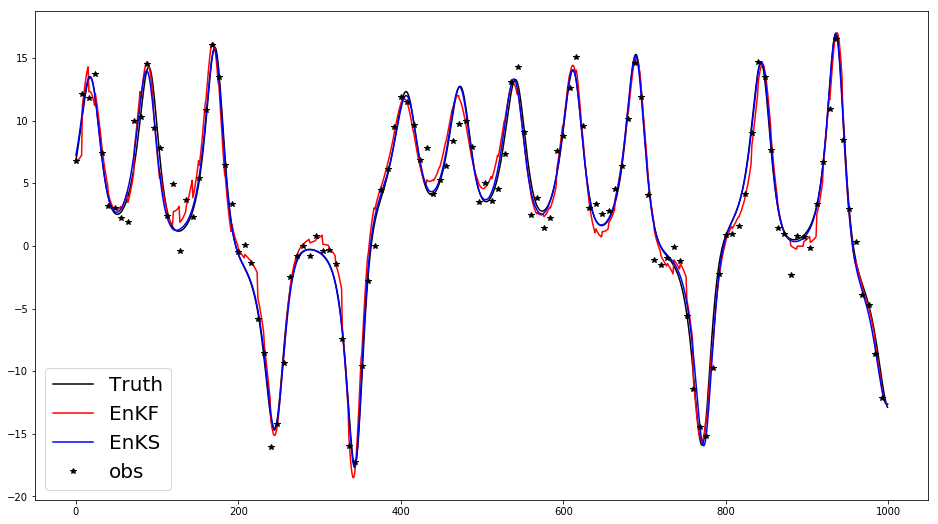

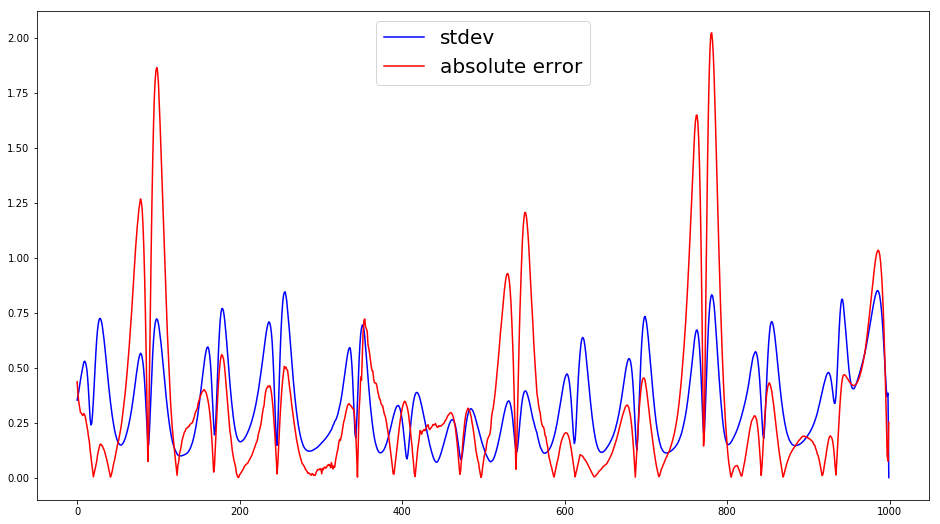

In [17]:
print "RMSE(xf): ", np.sqrt(np.mean(Err_xf**2.))
print "RMSE(xa): ", np.sqrt(np.mean(Err_xa**2.))
print "RMSE(xs): ", np.sqrt(np.mean(Err_xs**2.))

fig2 = plt.figure(figsize=(16,9))
plt.plot(Xtrue.dot(H_true),'k')
plt.plot(np.mean(Xaens[:,:,0],1),'r')
plt.plot(np.mean(Xsens[:,:,0],1),'b')
plt.plot(Yobs,'k*')
plt.legend(['Truth','EnKF','EnKS','obs'],fontsize = 20)


fig3 = plt.figure(figsize = (16,9))
plt.plot(np.sqrt(Ps_all[:,0,0]),'b')
plt.plot(Err_xs,'r')
plt.legend(['stdev','absolute error'],fontsize = 20)
plt.show()


# Programming Assignment 2

Review the code and try to understand the meaning of the parameters <font color='blue'>dt, dt_obs, Ne, AF_k, H_true, n, L_lag, T_c, T_t</font>. Now you can play with the code by changing these parameters. In this assignment, you have the following tasks:

### Task 1:
Use other lags. Compare the attractor of the lagged state and the quality of the reanslysis with different lags. Explain the difference.  

### Task 2:
Run the code with small catalog size and large catalog size. Are the results different? Explain.

### Task 3:
Run the code with small ensemble size and large ensemble size. Are the results different? Explain.

### Task 4:
Run the code with lagged state variables and without lagged state varaibles. Are the results different? Explain.

### Task 5:
Run the code with sparse observations and frequent observations. Are the results different? Explain.

### Task 6:
Change the observation operator. Check if the code works or not.

# Programming Assignment 3

If you have time, code for optimal interpolation and compare the results with the xs computed from AnDA.
